In [1]:
import sys
import os
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import pyemma
import msmtools
import mdtraj as md

import ivac
import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots

cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# original data + previous supplemental sampling

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
# sb_trajs = []
# for i in range(6):
#     sb_trajs.extend(np.load(f'../../data/raw_feat/feat2_suppl_{i:02d}.npy', allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [7]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3790079, 2) (3790079, 60)


# PMF

In [9]:
weights = np.load("../../data/feat2_dist_du_anton2/weights_2.npy", allow_pickle=True)[0]

In [10]:
print(len(weights), weights[0].shape)

316 (10000,)


In [11]:
# PMFs
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

In [12]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights, xlim, ylim)

In [13]:
plt.rcParams['text.usetex'] = False

/scratch/local/jobs/3624569/ipykernel_647998/1072830311.py:9: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy
findfont: Font family ['"Computer Modern Sans Serif"'] not found. Falling back to DejaVu Sans.


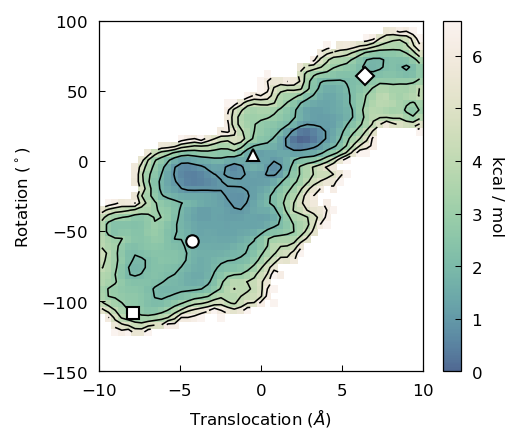

In [14]:
clines = np.linspace(0, 6, 7)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(3.5, 3))

# calculate energy difference against minimum
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff * 0.593, cmap=cm_seq)
cb = plt.colorbar(h, ax=ax)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
ax.contour(centerx, centery, diff * 0.593, levels=clines, colors="black")
plotting.format_cvs(ax, centroids=True, ms=6)
f.tight_layout()

In [15]:
sb_ids = [42, 48, 47, 53]

In [16]:
# PMFs in sb space
pmfs_sb = []
sb1_lim = []
sb2_lim = []
for (sb1, sb2) in combinations(sb_ids, 2):
    sb1_trajs = [traj[:, sb1] for traj in sb_trajs]
    sb2_trajs = [traj[:, sb2] for traj in sb_trajs]
    xlim = np.linspace(np.min(sb_arr[:, sb1]), np.max(sb_arr[:, sb1]), 100)
    ylim = np.linspace(np.min(sb_arr[:, sb2]), np.max(sb_arr[:, sb2]), 100)
    sb1_lim.append(xlim)
    sb2_lim.append(ylim)
    pmfs_sb.append(extq.projection.density2d(sb1_trajs, sb2_trajs, weights, xlim, ylim))

/project/dinner/scguo/ci-vsd/notebooks/anton2/../../python/plotting.py:125: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


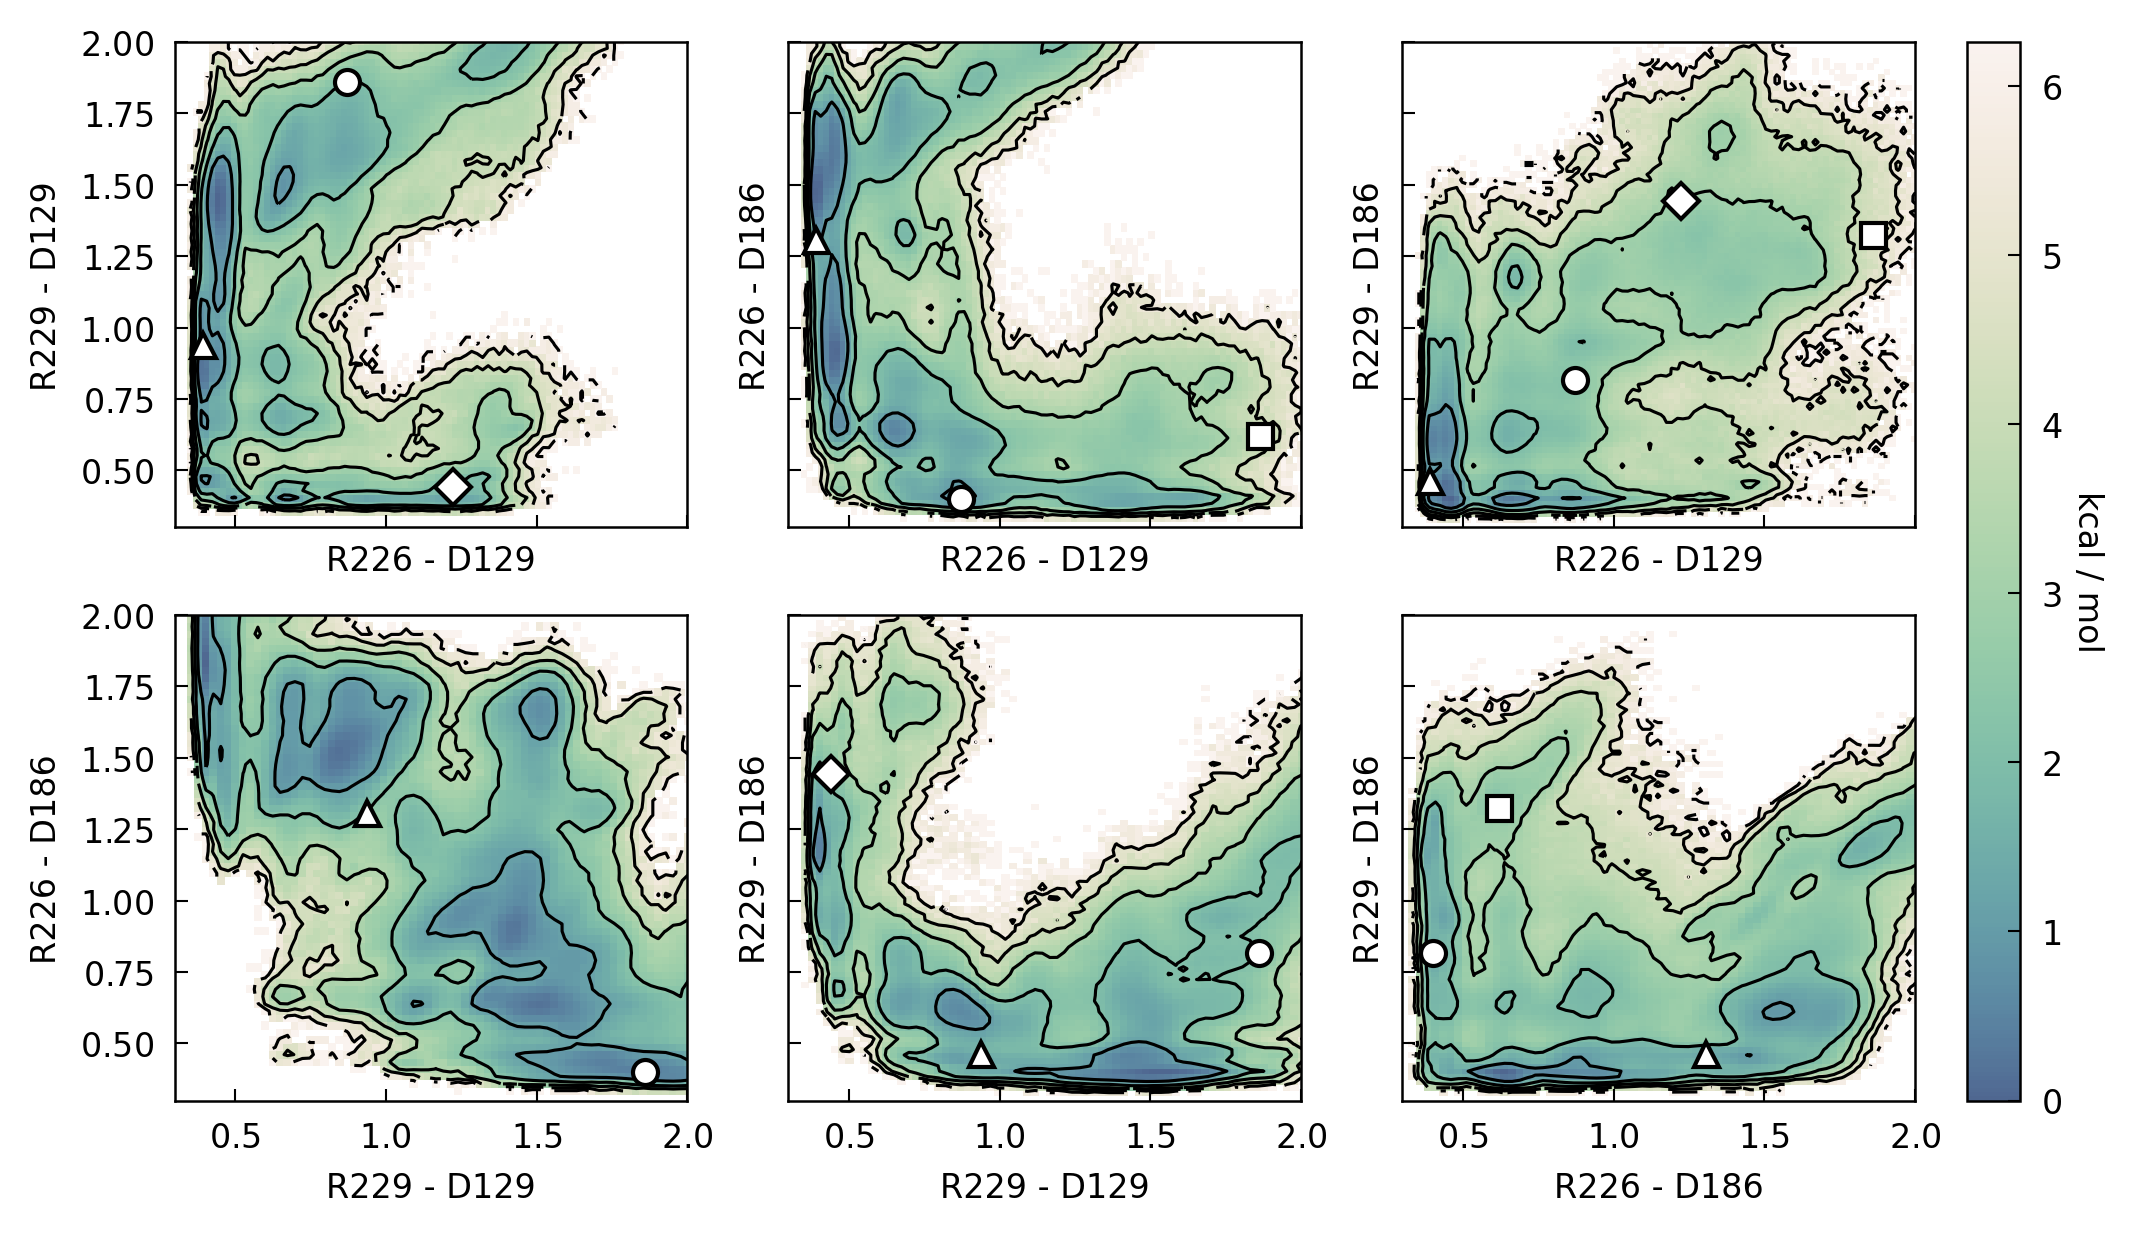

In [17]:
f, axes = plotting.plot_sb_pmfs(
    sb_ids,
    pmfs_sb,
    sb1_lim,
    sb2_lim,
    cmap=cm_seq,
    units="kcal",
    fig_kwargs={
        "sharex": True,
        "sharey": True,
        "constrained_layout": True,
        "figsize": (7, 4),
        "dpi": 300,
    }
)
plotting.plot_sb_models(axes.flat, mode="du", ms=6)

In [42]:
def sb_pmfs(sb_ids, sb_trajs, weights):
    # PMFs in sb space
    pmfs_sb = []
    sb1_lim = []
    sb2_lim = []
    for (sb1, sb2) in combinations(sb_ids, 2):
        sb1_trajs = [traj[:, sb1] for traj in sb_trajs]
        sb2_trajs = [traj[:, sb2] for traj in sb_trajs]
        xlim = np.linspace(np.min(sb_arr[:, sb1]), np.max(sb_arr[:, sb1]), 100)
        ylim = np.linspace(np.min(sb_arr[:, sb2]), np.max(sb_arr[:, sb2]), 100)
        sb1_lim.append(xlim)
        sb2_lim.append(ylim)
        pmfs_sb.append(
            extq.projection.density2d(sb1_trajs, sb2_trajs, weights, xlim, ylim)
        )

    return pmfs_sb, sb1_lim, sb2_lim

In [22]:
def plot_sb_pmfs(
    sb_ids,
    pmfs_sb,
    sb1_lim,
    sb2_lim,
    clines=None,
    cmap=None,
    units="kT",
    fig_kwargs=None,
    **kwargs,
):
    if clines is None:
        clines = np.linspace(0, 6, 7)
    if cmap is None:
        cmap = cm_div
    if units != "kT" and units != "kcal":
        raise ValueError("Units must be in kT or kcal!")
    if fig_kwargs is None:
        fig_kwargs = {"sharex": True, "sharey": True, "constrained_layout": True}

    f, axes = plt.subplots(2, 3, **fig_kwargs)

    for ((sb1, sb2), ax, p, xlim, ylim) in zip(
        combinations(sb_ids, 2), axes.flat, pmfs_sb, sb1_lim, sb2_lim
    ):
        # compute grid
        centerx = (xlim[1:] + xlim[:-1]) / 2
        centery = (ylim[1:] + ylim[:-1]) / 2

        # calculate energy difference against minimum
        min_energy = np.min(-np.log(p[np.nonzero(p)]))
        diff = -np.log(p.T) - min_energy
        if units == "kcal":
            diff *= 0.593
        h = ax.pcolor(xlim, ylim, diff, cmap=cm_seq)
        ax.contour(
            centerx,
            centery,
            diff,
            levels=clines,
            colors="black",
            linestyles="solid",
        )

        ax.set_xlabel(f"{sb_labels[sb1 - 30]}")
        ax.set_ylabel(f"{sb_labels[sb2 - 30]}")
        ax.set_xlim([0.3, 2.0])
        ax.set_ylim([0.3, 2.0])

    cb = plt.colorbar(h, ax=axes[:, -1])
    if units == "kT":
        cb.set_label("kT", rotation=-90, labelpad=10)
    elif units == "kcal":
        cb.set_label("kcal / mol", rotation=-90, labelpad=10)

    return f, axes

In [23]:
sb_ids_dd = [i - 6 for i in sb_ids]
pmfs_sb_dd, sb1_lim_dd, sb2_lim_dd = sb_pmfs(sb_ids_dd, sb_trajs, weights)

/scratch/local/jobs/3601250/ipykernel_2449826/4265080895.py:32: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(p.T) - min_energy


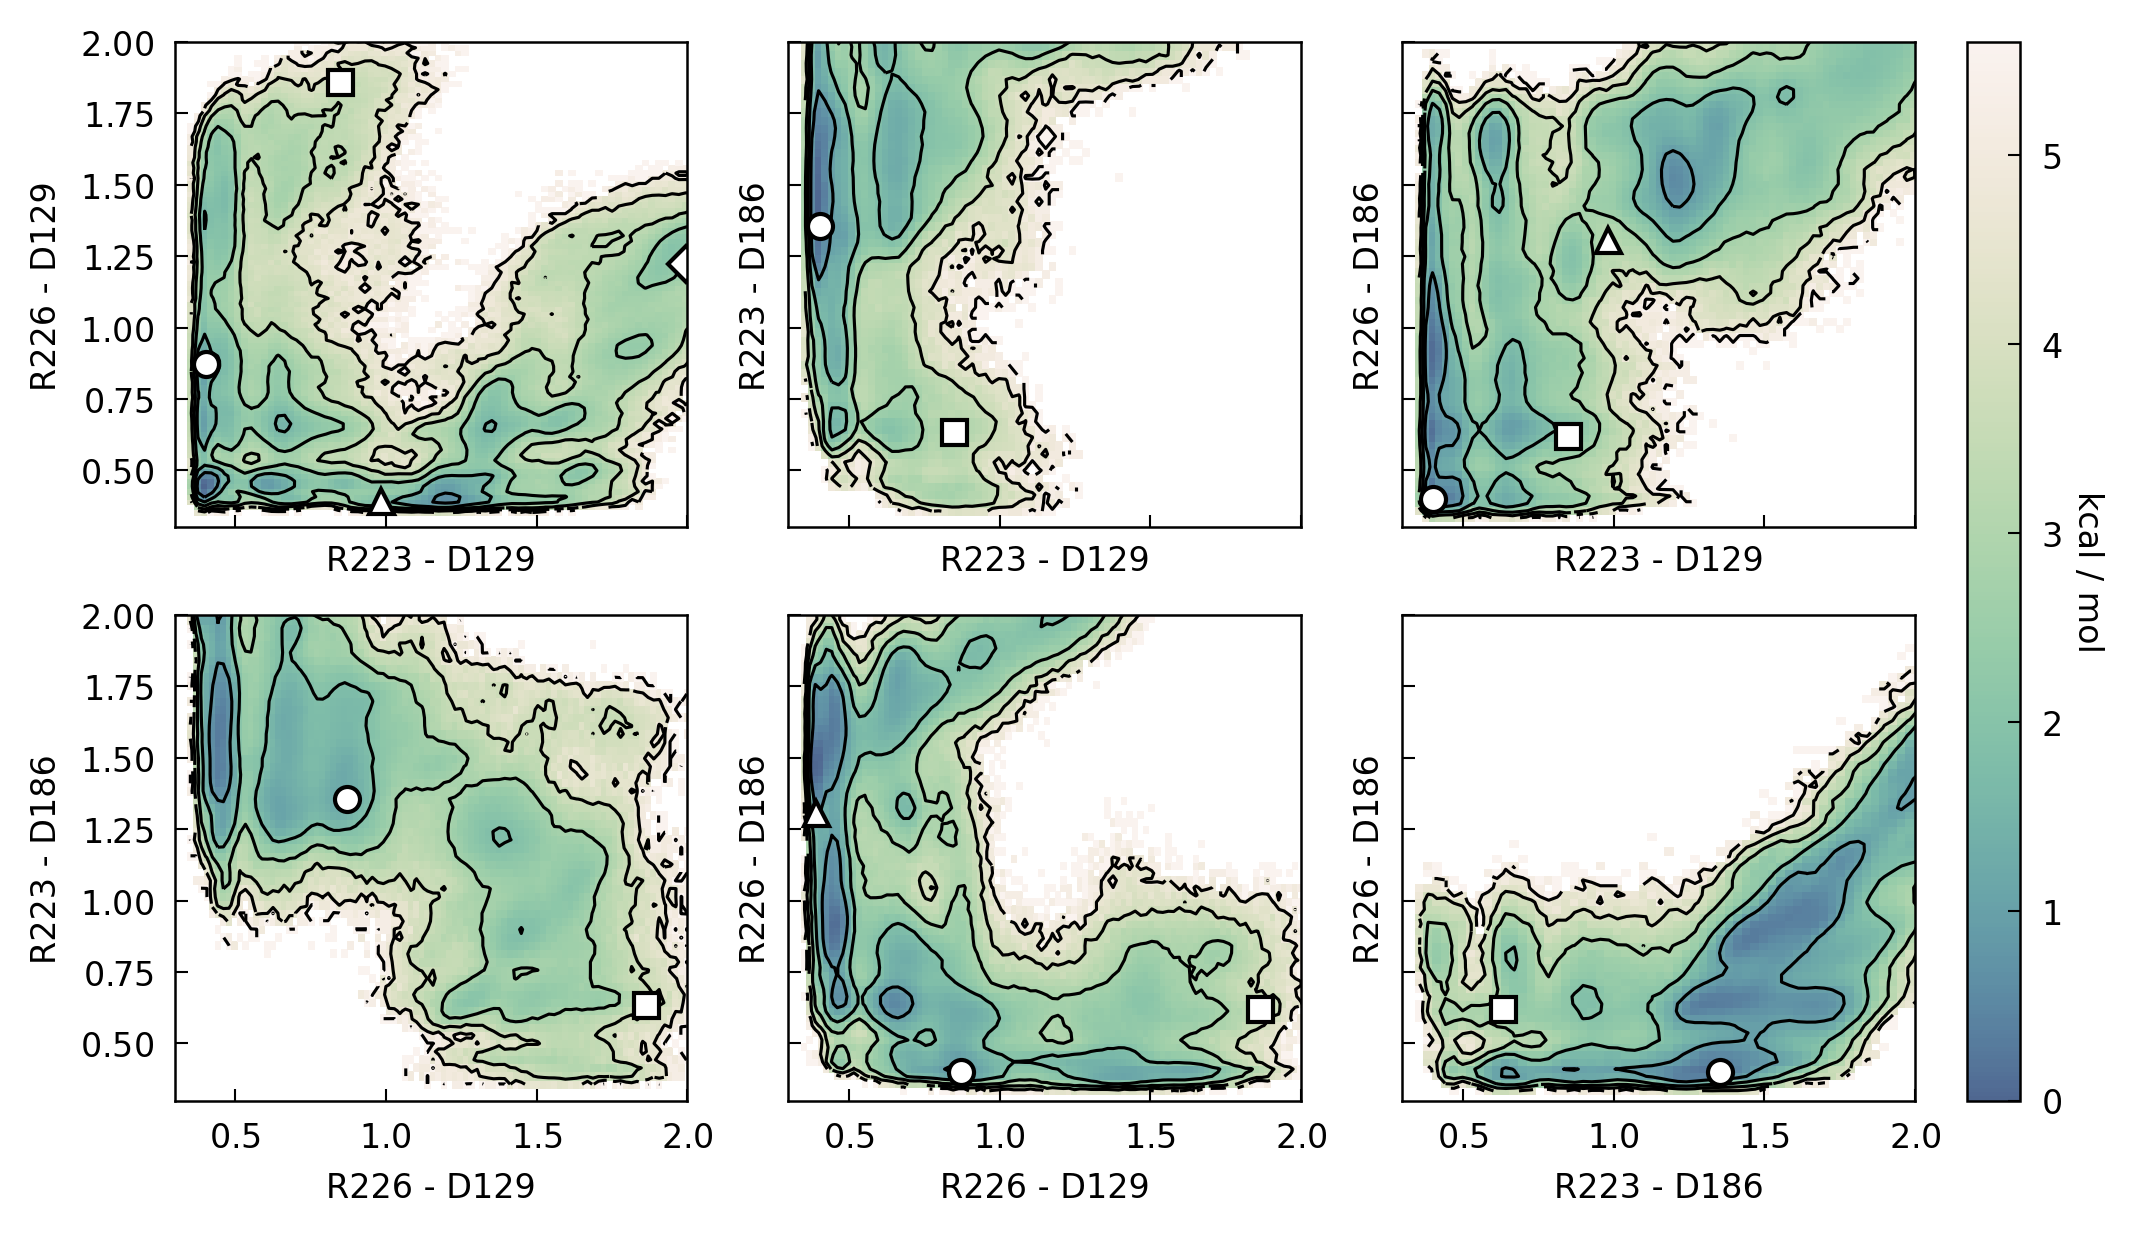

In [25]:
f, axes = plot_sb_pmfs(
    sb_ids_dd,
    pmfs_sb_dd,
    sb1_lim_dd,
    sb2_lim_dd,
    units="kcal",
    cmap=cm_seq,
    fig_kwargs={
        "sharex": True,
        "sharey": True,
        "constrained_layout": True,
        "figsize": (7, 4),
        "dpi": 300,
    },
)
plotting.plot_sb_models(axes.flat, mode="dd", ms=6)

In [26]:
sb_ids_uu = [i + 6 for i in sb_ids]
pmfs_sb_uu, sb1_lim_uu, sb2_lim_uu = sb_pmfs(sb_ids_uu, sb_trajs, weights)

/scratch/local/jobs/3601250/ipykernel_2449826/4265080895.py:32: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(p.T) - min_energy


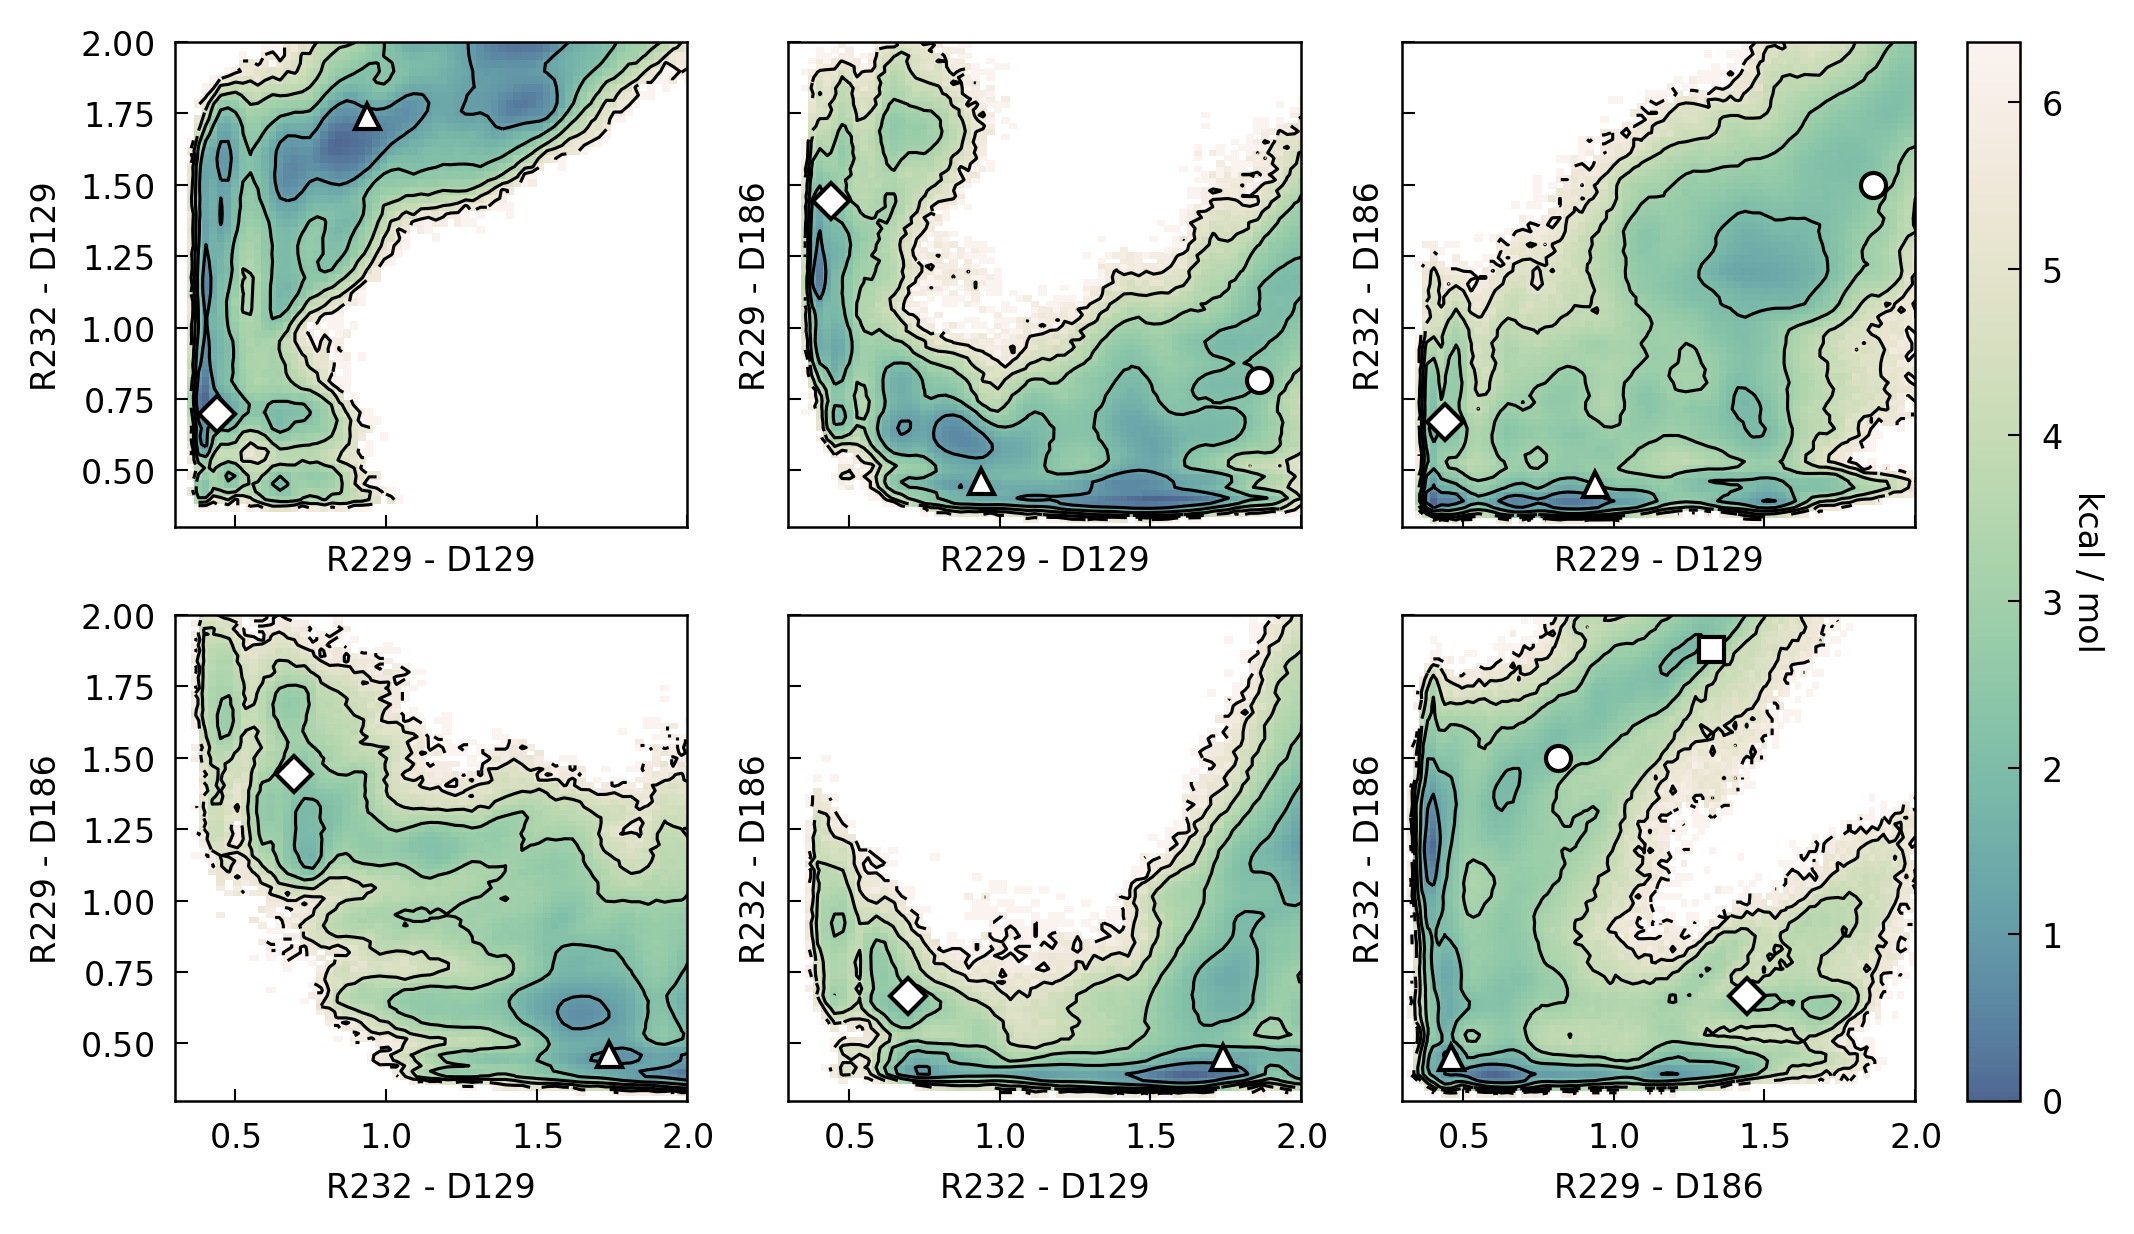

In [27]:
f, axes = plot_sb_pmfs(
    sb_ids_uu,
    pmfs_sb_uu,
    sb1_lim_uu,
    sb2_lim_uu,
    units="kcal",
    cmap=cm_seq,
    fig_kwargs={
        "sharex": True,
        "sharey": True,
        "constrained_layout": True,
        "figsize": (7, 4),
        "dpi": 300,
    },
)
plotting.plot_sb_models(axes.flat, mode="uu", ms=6)

# New seeds

near up state at $(d, \theta) = (-2, 20)$

In [28]:
q = np.load("../../data/feat2_dist_du_anton2/q_downup_1.npy", allow_pickle=True)[
    6
]  # 10 ns
q_arr = np.concatenate(q)

In [24]:
for i in util.find_closest_points((-2, 20), cv_arr, n=20):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(83, 2), 0.8802933751197497
(264, 9352), 0.6070545730765621
(83, 2421), 0.937859208203627
(34, 7293), 0.8438524931599539
(83, 20), 0.8728077275384688
(34, 7289), 0.8585627214595174
(34, 6655), 0.8772224593565207
(34, 9527), 0.8340227927041918
(83, 3381), 0.9187813981510136
(83, 10), 0.8781874586962564
(264, 9137), 0.6265951445433595
(34, 6663), 0.8310806023430231
(34, 6661), 0.8509929553408415
(34, 6665), 0.8252893558740289
(34, 7294), 0.8477216100374096
(83, 18), 0.8731658903925305
(34, 6659), 0.8454701965996271
(34, 6637), 0.8759962369032093
(83, 3364), 0.9225759161915418
(264, 9328), 0.5840387861462768


In [25]:
for i in util.find_closest_points((-1.5, 25), cv_arr, n=20):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(34, 5650), 0.9176680893731355
(34, 5639), 0.8966927748056334
(34, 7330), 0.840561240783952
(83, 2229), 0.8942139836764834
(34, 9218), 0.8628449888922793
(34, 5649), 0.9060658992677341
(34, 9320), 0.7902743209376021
(34, 6747), 0.8662716090238998
(34, 7295), 0.8509307763211698
(34, 5760), 0.8601927267824643
(34, 5677), 0.8684396397963843
(34, 7307), 0.8501506994928135
(83, 3388), 0.9186317288914747
(34, 6102), 0.8815584432383095
(34, 6668), 0.8618631967583477
(34, 9366), 0.7942398144847354
(34, 7380), 0.8341995439226577
(34, 5598), 0.8928098225542763
(34, 9322), 0.7700779041509205
(34, 9214), 0.8417939387683308


In [26]:
sb1 = sb_ids_dd[0]
sb2 = sb_ids_dd[1]
for i in util.find_closest_points((0.6, 0.8), sb_arr[:, [sb1, sb2]], n=10):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(257, 3814), 0.5641290312974778
(22, 5844), 0.4439344875327742
(22, 5694), 0.42825941879127827
anton2 46, 206, 0.8600475372343347
(53, 5720), 0.033031981266711884
(109, 9355), 0.06791336310917159
(59, 7932), -0.0020829845908798966
(22, 5450), 0.3769473820786131
(257, 7924), 0.6159388435774147
(109, 7290), 0.04716803489478576


In [27]:
sb1 = sb_ids_dd[0]
sb2 = sb_ids_dd[1]
for i in util.find_closest_points((0.6, 0.9), sb_arr[:, [sb1, sb2]], n=10):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(161, 5221), 0.030689128298991494
(160, 6793), 0.052138317790193636
(2, 6508), 0.09269402429651387
(180, 42060), 0.03657405849546538
(257, 7749), 0.5703406065176031
(53, 2387), 0.022476216038896393
(116, 5718), 0.05009432299677914
(53, 8520), 0.029339530009061497
(55, 2065), -0.022731847253613754
anton2 21, 9304, 0.06119438805282737


In [28]:
sb1 = sb_ids_dd[0]
sb2 = sb_ids_dd[1]
for i in util.find_closest_points((0.7, 0.8), sb_arr[:, [sb1, sb2]], n=10):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(154, 8653), 0.08870081966218236
(109, 7140), 0.08366658582294235
(180, 31608), 0.06866897899560866
(180, 7816), 0.03633460459029573
(50, 7816), 0.03633460459029573
(109, 7594), 0.04273824527255642
(180, 71303), 0.13213781140598224
anton2 46, 590, 0.8948853473404885
(55, 2068), 0.014938581878291002
anton2 47, 8161, 0.8523224206947846


In [29]:
sb1 = sb_ids_dd[1]
sb2 = sb_ids_dd[2]
for i in util.find_closest_points((1.1, 1.2), sb_arr[:, [sb1, sb2]], n=10):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(179, 8688), 0.06857595340669051
anton2 7, 5558, 0.08549123188543918
(2, 404), 0.05920492279034474
(9, 605), 0.0961180416859034
(171, 2894), 0.029012057818769012
(54, 1454), 0.014935283099739599
(179, 8160), 0.047170076128531954
(179, 8169), 0.049664076004270655
(179, 8729), 0.06018670435027751
(107, 1065), 0.04256766560700019


In [30]:
sb1 = sb_ids_dd[1]
sb2 = sb_ids_dd[2]
for i in util.find_closest_points((1.0, 1.0), sb_arr[:, [sb1, sb2]], n=10):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(2, 92), 0.12961730510183728
(179, 9162), 0.008457511331504998
(179, 8630), 0.037438843313687825
anton2 7, 5758, 0.07037242243276857
(179, 8631), 0.055680001752520324
(154, 5287), -0.0027206266942293444
(154, 5681), -0.004509929040024965
(179, 10935), 0.027207942776650732
(154, 5963), -0.020787114761306222
anton2 7, 5597, 0.06454976650628207


In [31]:
sb1 = sb_ids_dd[1]
sb2 = sb_ids_dd[3]
for i in util.find_closest_points((1.2, 0.55), sb_arr[:, [sb1, sb2]], n=10):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

anton2 11, 4449, 0.03921555785683834
(154, 4507), 0.035901498492733705
(55, 2960), -0.03179299925819966
(160, 1370), 0.012152034985784446
(1, 6365), 0.05063682615417393
(104, 531), 0.0033564401766523165
(179, 8716), 0.06346056372833755
(2, 4483), 0.012176848389548139
(51, 8092), 0.09802237758575333
(160, 1250), 0.009583849437969319


# New seeds

3.15.22

In [29]:
# maximum flux in q direction
j_du_q = np.load("../../data/feat2_dist_du_anton2/j_du_q.npy", allow_pickle=True)[5] # 5 ns
j_du_ds = np.load("../../data/feat2_dist_du_suppl_2/j_du_ds.npy", allow_pickle=True)[5]
q = np.load("../../data/feat2_dist_du_anton2/q_downup_1.npy", allow_pickle=True)[
    6
]  # 10 ns
q_arr = np.concatenate(q)

In [33]:
q_ts_inds = ((q_arr > 0.4) & (q_arr < 0.6)).nonzero()[0]
jq_ts = np.concatenate(j_du_q)[q_ts_inds]
jd_ts = np.concatenate(j_du_ds[:, 0])[q_ts_inds]
js_ts = np.concatenate(j_du_ds[:, 1])[q_ts_inds]
print(q_ts_inds.shape, jq_ts.shape, jd_ts.shape, js_ts.shape)

(206713,) (206713,) (206713,) (206713,)


In [34]:
cv_ts = cv_arr[q_ts_inds]

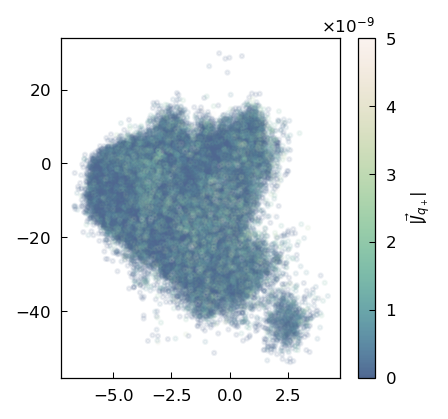

In [35]:
sc = plt.scatter(cv_ts[:, 0], cv_ts[:, 1], c=jq_ts, cmap=cm_seq, vmin=0, vmax=5e-9, alpha=0.1)
cb = plt.colorbar(sc)
cb.solids.set(alpha=1)
cb.set_label("$| \\vec{J}_{q_+} |$")

In [51]:
for i in np.argsort(jq_ts)[:-20:-1]:
    j = q_ts_inds[i]
    if j < 3_000_000:
        print(f"orig: \t{util.anton_frame(j)}: \t{cv_arr[j]}, \t{jq_ts[i]}, \t{q_arr[j]}")
    else:
        k = j - 3_000_000
        print(f"anton2:\t({k // 10001}, {k % 10001}): \t{cv_ts[i]}, \t{jq_ts[i]}, \t{q_arr[j]}")

anton2:	(27, 533): 	[ -0.829 -37.449], 	1.5052963624200046e-08, 	0.4697033763118187
orig: 	(125, 203): 	[-2.723 -9.322], 	1.2275628869672926e-08, 	0.5036756167524705
anton2:	(27, 527): 	[ -0.873 -35.983], 	1.2047241039039664e-08, 	0.4063586805940026
orig: 	(125, 169): 	[ -2.485 -12.684], 	1.1689387784204162e-08, 	0.5133423291157386
anton2:	(38, 257): 	[ -1.292 -10.374], 	1.0304381815275384e-08, 	0.48537744700118773
anton2:	(27, 121): 	[ -1.788 -28.188], 	9.909806331824173e-09, 	0.4354129222966542
anton2:	(40, 6267): 	[ -3.079 -15.191], 	9.876497591627973e-09, 	0.4784459046166768
orig: 	(201, 8906): 	[-3.349 -6.056], 	9.448063309715604e-09, 	0.4916455118147572
orig: 	(121, 939): 	[-2.2   -2.735], 	9.415936852901126e-09, 	0.4525982326139658
orig: 	(280, 79): 	[ -1.393 -11.17 ], 	9.346029867944365e-09, 	0.5515877075515788
anton2:	(40, 5415): 	[-3.83  -9.926], 	9.099671198951719e-09, 	0.40933357572046325
orig: 	(63, 3125): 	[-3.    -8.652], 	9.053811529088627e-09, 	0.4172097166141118
anton

## New Seeds 3.21.22

In [32]:
weights = np.load("../../data/feat2_dist_du_anton2/weights_2.npy", allow_pickle=True)[0]
q = np.load("../../data/feat2_dist_du_anton2/q_downup_2.npy", allow_pickle=True)[8]

In [51]:
# PMFs
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 200)
ylim = np.linspace(-150, 100, 200)

In [52]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights, xlim, ylim)

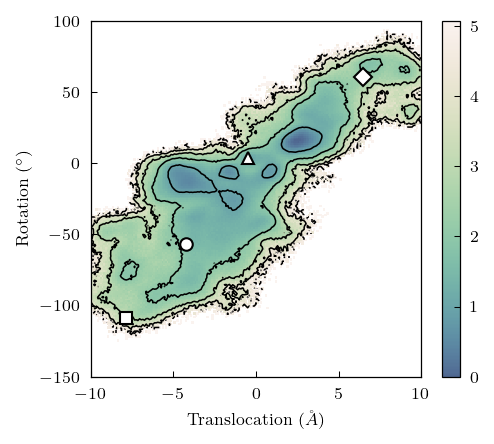

In [38]:
clines = np.linspace(0, 6, 7)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(3.5, 3))

# calculate energy difference against minimum
ax, h = plotting.plot_pmf(ax, pmf, xlim, ylim, units='kcal', clines=clines, cmap=cm_seq)
plotting.format_cvs(ax, centroids=True, ms=6)
plt.colorbar(h, ax=ax)
f.tight_layout()

/project/dinner/scguo/ci-vsd/notebooks/anton2/../../python/plotting.py:125: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


(-75.0, 25.0)

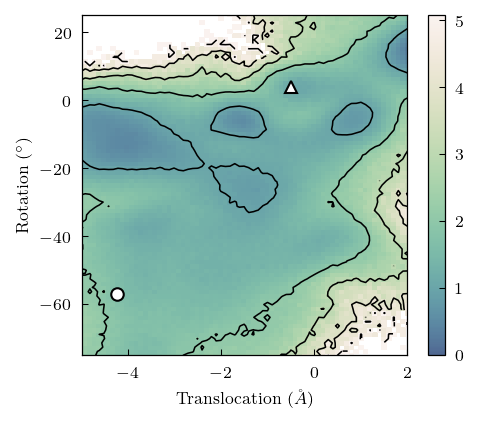

In [53]:
clines = np.linspace(0, 6, 7)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(3.5, 3))

# calculate energy difference against minimum
ax, h = plotting.plot_pmf(ax, pmf, xlim, ylim, units='kcal', clines=clines, cmap=cm_seq)
plotting.format_cvs(ax, centroids=True, ms=6)
plt.colorbar(h, ax=ax)
plt.xlim([-5, 2])
plt.ylim([-75, 25])

In [39]:
sb_ids = [42, 48, 47, 53]

In [40]:
# PMFs in sb space
pmfs_sb = []
sb1_lim = []
sb2_lim = []
for (sb1, sb2) in combinations(sb_ids, 2):
    sb1_trajs = [traj[:, sb1] for traj in sb_trajs]
    sb2_trajs = [traj[:, sb2] for traj in sb_trajs]
    xlim = np.linspace(np.min(sb_arr[:, sb1]), np.max(sb_arr[:, sb1]), 200)
    ylim = np.linspace(np.min(sb_arr[:, sb2]), np.max(sb_arr[:, sb2]), 200)
    sb1_lim.append(xlim)
    sb2_lim.append(ylim)
    pmfs_sb.append(extq.projection.density2d(sb1_trajs, sb2_trajs, weights, xlim, ylim))

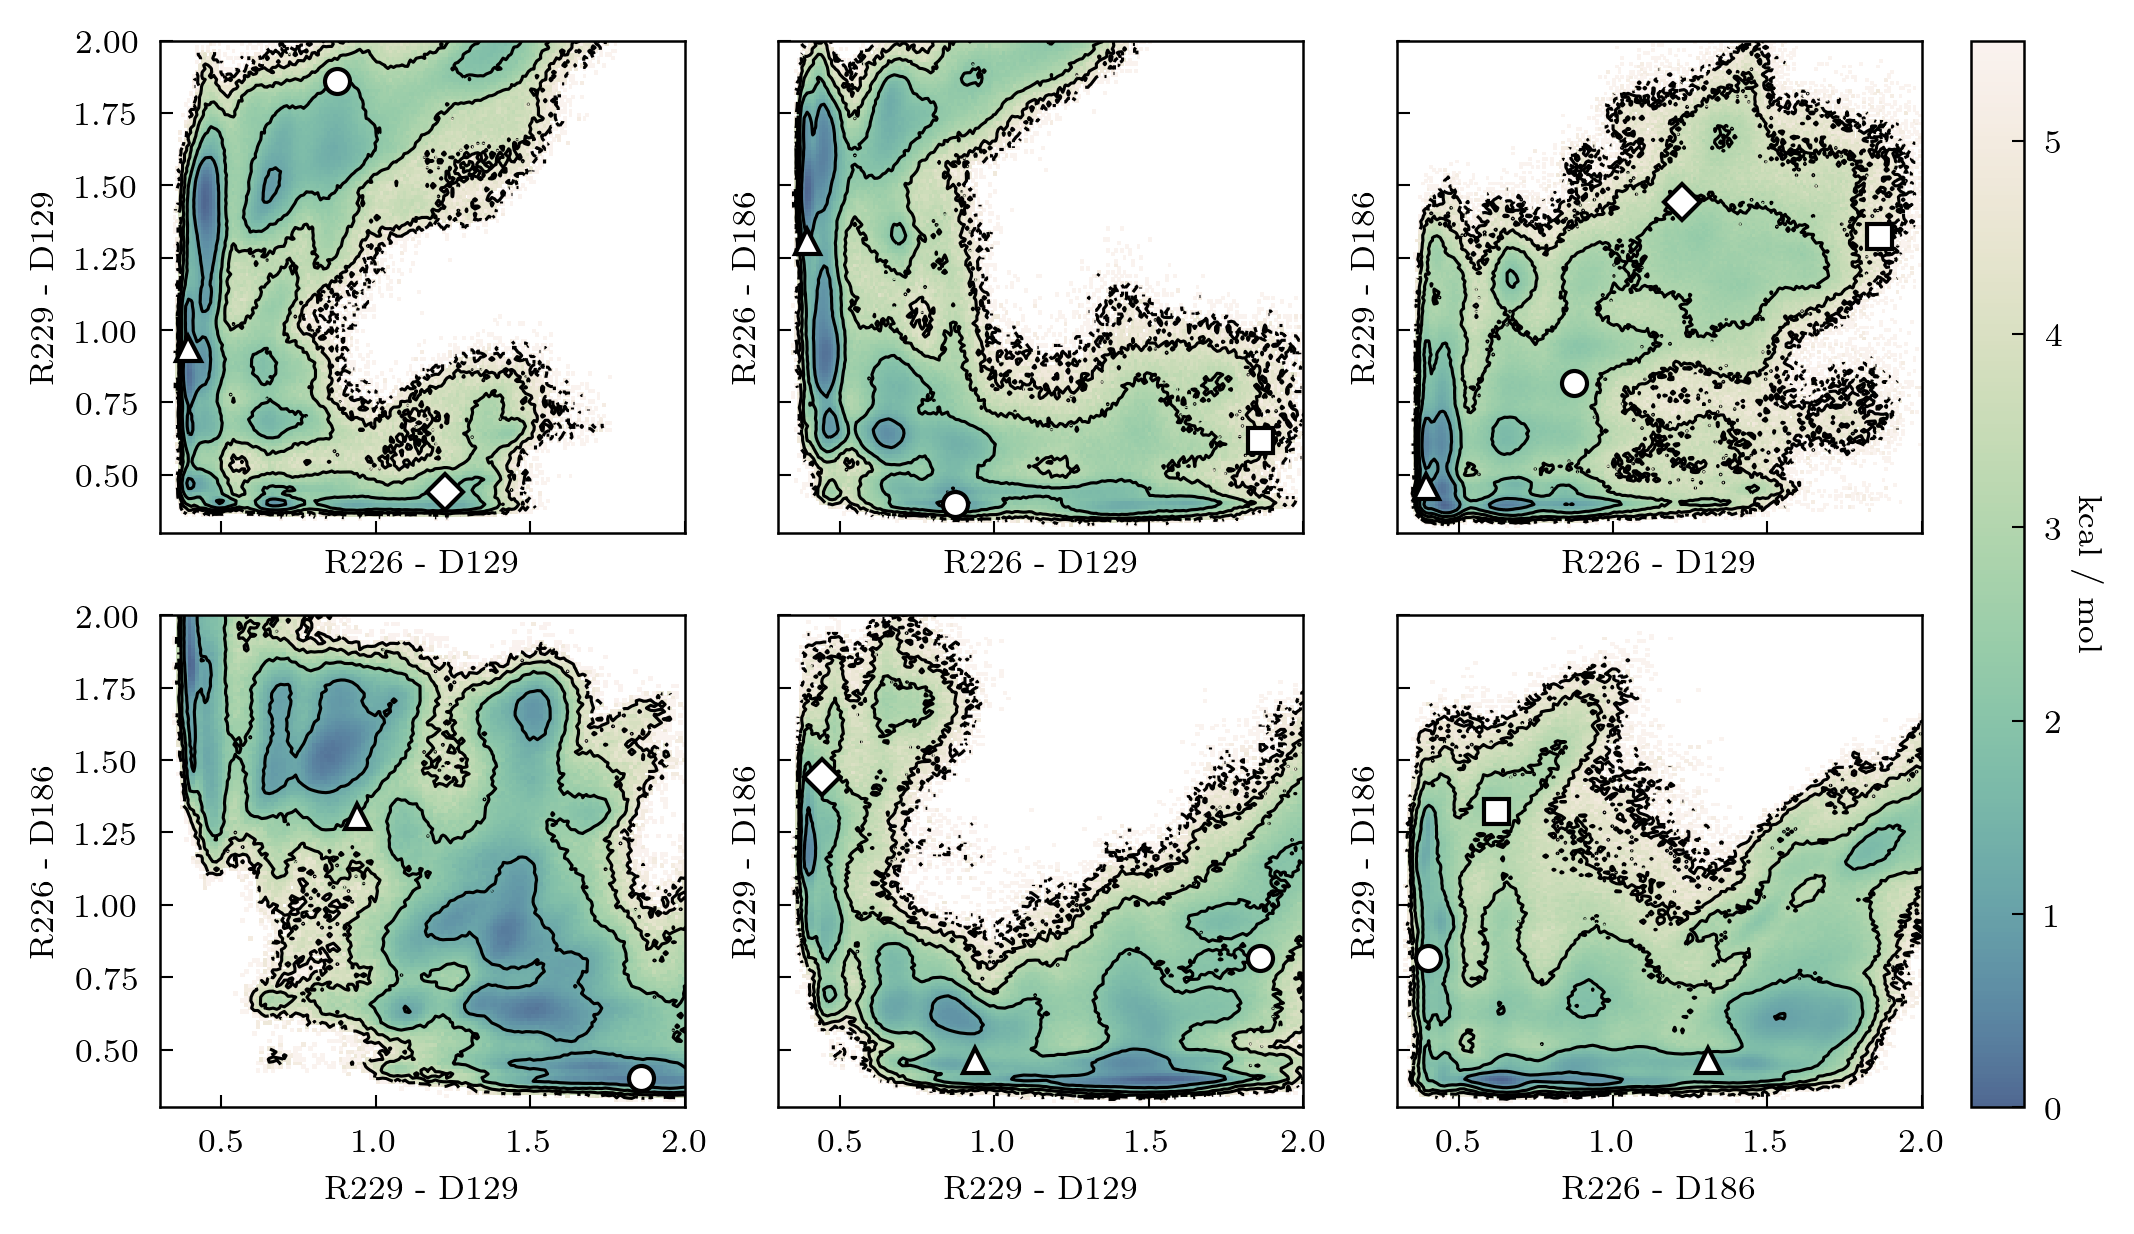

In [41]:
f, axes = plotting.plot_sb_pmfs(
    sb_ids,
    pmfs_sb,
    sb1_lim,
    sb2_lim,
    cmap=cm_seq,
    units="kcal",
    fig_kwargs={
        "sharex": True,
        "sharey": True,
        "constrained_layout": True,
        "figsize": (7, 4),
        "dpi": 300,
    }
)
plotting.plot_sb_models(axes.flat, mode="du", ms=6)

In [43]:
sb_ids_dd = [i - 6 for i in sb_ids]
pmfs_sb_dd, sb1_lim_dd, sb2_lim_dd = sb_pmfs(sb_ids_dd, sb_trajs, weights)

/project/dinner/scguo/ci-vsd/notebooks/anton2/../../python/plotting.py:125: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


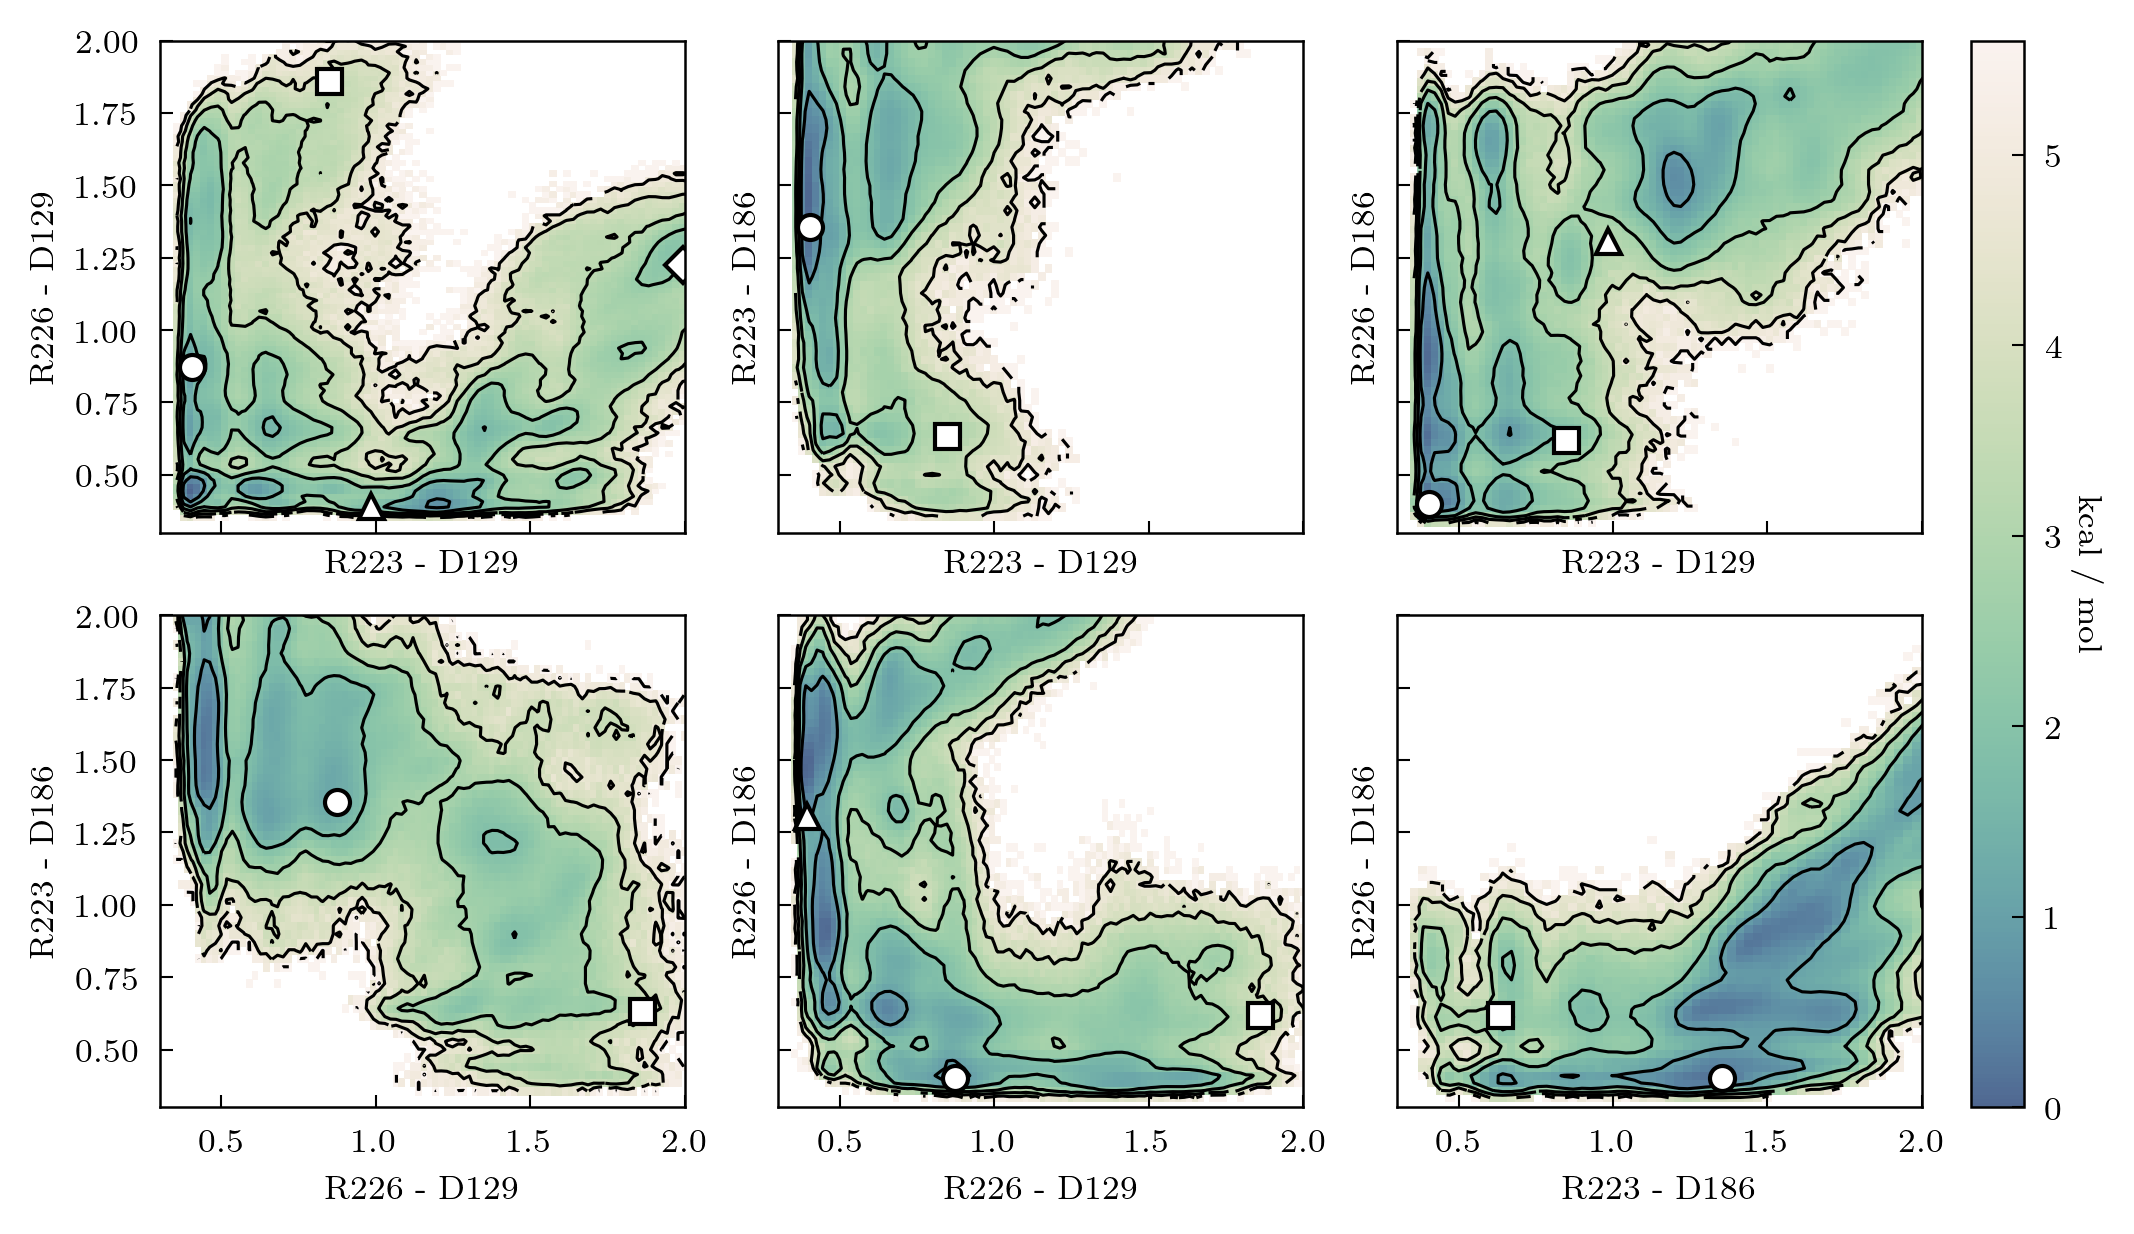

In [45]:
f, axes = plotting.plot_sb_pmfs(
    sb_ids_dd,
    pmfs_sb_dd,
    sb1_lim_dd,
    sb2_lim_dd,
    units="kcal",
    cmap=cm_seq,
    fig_kwargs={
        "sharex": True,
        "sharey": True,
        "constrained_layout": True,
        "figsize": (7, 4),
        "dpi": 300,
    },
)
plotting.plot_sb_models(axes.flat, mode="dd", ms=6)

In [46]:
sb_ids_uu = [i + 6 for i in sb_ids]
pmfs_sb_uu, sb1_lim_uu, sb2_lim_uu = sb_pmfs(sb_ids_uu, sb_trajs, weights)

/project/dinner/scguo/ci-vsd/notebooks/anton2/../../python/plotting.py:125: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


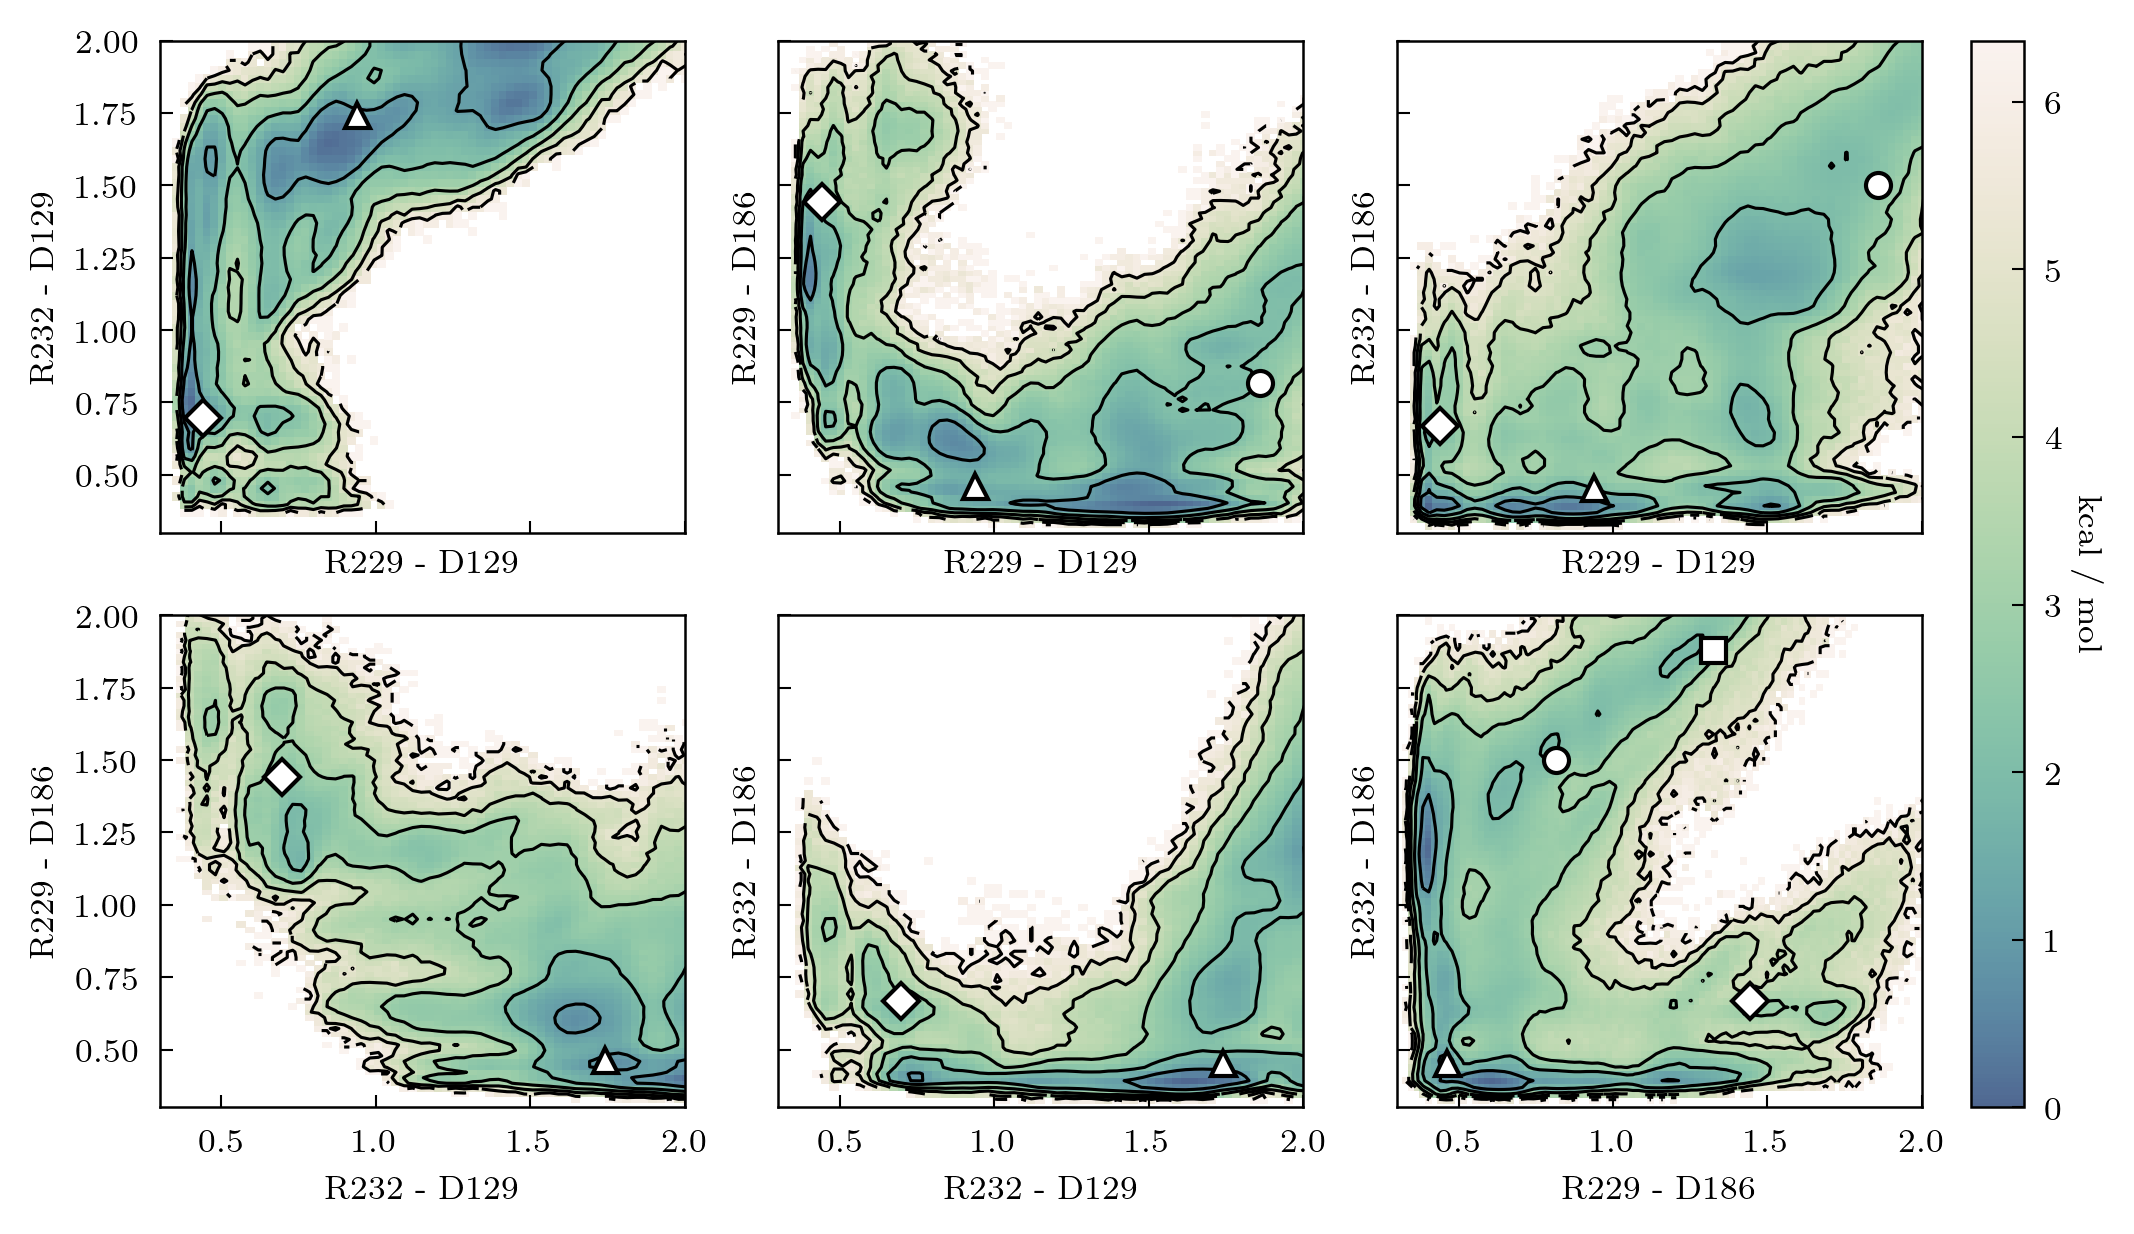

In [48]:
f, axes = plotting.plot_sb_pmfs(
    sb_ids_uu,
    pmfs_sb_uu,
    sb1_lim_uu,
    sb2_lim_uu,
    units="kcal",
    cmap=cm_seq,
    fig_kwargs={
        "sharex": True,
        "sharey": True,
        "constrained_layout": True,
        "figsize": (7, 4),
        "dpi": 300,
    },
)
plotting.plot_sb_models(axes.flat, mode="uu", ms=6)

In [49]:
q_arr = np.concatenate(q)

In [55]:
for i in util.find_closest_points((-1, 10), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(221, 6944), 0.7369528052223002
(24, 6641), 1.0
(256, 878), 0.6508225035280443


In [56]:
for i in util.find_closest_points((-0.5, 10), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(196, 9170), 0.6608327604673642
(265, 6288), 0.6577873124798335
(90, 3301), 0.9168853208093874


In [57]:
for i in util.find_closest_points((-1, 15), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(83, 3018), 0.9926174740119503
(34, 915), 0.9239149766930874
(83, 3107), 0.9563953690432795


In [61]:
for i in util.find_closest_points((-1, 20), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(34, 3003), 0.9238365417973167
(34, 9506), 0.8932510189277814
(34, 9444), 0.8503017990505961


In [59]:
for i in util.find_closest_points((-1.5, 10), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(265, 9951), 0.6394448396140358
(264, 8760), 0.602575108029973
(265, 9949), 0.6300933813243658


In [60]:
for i in util.find_closest_points((-1.75, 10), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(264, 9074), 0.6147715609619645
(121, 1573), 0.7103410859209849
(181, 15353), 0.5656464619086002


In [62]:
for i in util.find_closest_points((1, -30), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

anton2 48, 9388, 0.9312537983691698
anton2 72, 5190, 0.258733157705619
anton2 72, 6555, 0.24746553486019185


In [63]:
for i in util.find_closest_points((1.2, -30), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

anton2 71, 368, 0.21839857333215693
(62, 9206), 0.3363708507289518
(12, 6820), 0.15099112359747974


# New seeds 3.23.22

In [19]:
weights = np.load("../../data/feat2_dist_du_anton2/weights_2.npy", allow_pickle=True)[0]
q = np.load("../../data/feat2_dist_du_anton2/q_downup_2.npy", allow_pickle=True)[8]

In [20]:
q_arr = np.concatenate(q)

In [21]:
sb1, sb2 = sb_ids[1], sb_ids[3]
for i in util.find_closest_points((1.7, 0.5), sb_arr[:, [sb1, sb2]], n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

anton2 49, 2795, 0.8954661499004928
anton2 9, 7124, 0.08075562312179073
(18, 2851), 0.12057799890318172


In [22]:
sb1, sb2 = sb_ids[1], sb_ids[3]
for i in util.find_closest_points((1.8, 0.5), sb_arr[:, [sb1, sb2]], n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(53, 753), 0.02682222630682246
(216, 2359), 0.5864935852629292
anton2 73, 3340, 0.5995878871247273


In [23]:
sb1, sb2 = sb_ids[1], sb_ids[3]
for i in util.find_closest_points((1.9, 0.5), sb_arr[:, [sb1, sb2]], n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(1, 1933), 0.0388762122145395
anton2 61, 2607, 0.040520144366017245
anton2 61, 7860, 0.02088371033587197


In [65]:
sb1, sb2 = sb_ids[1], sb_ids[3]
for i in util.find_closest_points((1.7, 0.55), sb_arr[:, [sb1, sb2]], n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(55, 9900), 0.06970147814027446
(115, 6044), 0.030629790084098982
(53, 8872), 0.0329055586464327


In [66]:
sb1, sb2 = sb_ids[1], sb_ids[3]
for i in util.find_closest_points((1.8, 0.55), sb_arr[:, [sb1, sb2]], n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(59, 552), 0.0
(7, 625), 0.06593997729017764
anton2 73, 4825, 0.5172069809302278


In [67]:
sb1, sb2 = sb_ids[1], sb_ids[3]
for i in util.find_closest_points((1.25, 0.6), sb_arr[:, [sb1, sb2]], n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(249, 2243), 0.33365793015394707
(217, 3151), 0.6485459650626626
(202, 2246), 0.21883204271255136


In [68]:
sb1, sb2 = sb_ids[1], sb_ids[3]
for i in util.find_closest_points((1.25, 0.55), sb_arr[:, [sb1, sb2]], n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

anton2 13, 8598, 0.15028354234780833
(195, 693), 0.30682395146480845
anton2 13, 4192, 0.22075691229382716


In [69]:
for i in util.find_closest_points((0, -60), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

anton2 55, 2017, 0.08821345518665011
(153, 8410), 0.08634845421533928
anton2 55, 4565, 0.08088000358238678


In [70]:
for i in util.find_closest_points((-0.5, -60), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

(100, 7011), 0.059571434944990176
(153, 8478), 0.06307434584623456
anton2 37, 3010, 0.9277120683037433


In [71]:
for i in util.find_closest_points((0, -55), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

anton2 55, 6176, 0.07233873614363308
anton2 35, 3101, 0.9239673464435969
anton2 47, 7108, 0.8319130862514225


In [74]:
for i in util.find_closest_points((-0.5, -55), cv_arr, n=3):
    if i < 3_000_000:
        print(f"{util.anton_frame(i)}, {q_arr[i]}")
    else:
        i -= 3_000_000
        print(f"anton2 {i // 10001 + 3}, {i % 10001}, {q_arr[i]}")

anton2 55, 2031, 0.07492292424901645
(20, 2206), 0.08373972871582758
(153, 9474), 0.06982993017660294


In [ ]:
md.load_dtr("/beagle3/dinner/scguo/anton2-backup/workdir.73/jobsteps/000000-00072503/run.dtr", frame=9999, top="../../unbiased/000/civsd.pdb")

<mdtraj.Trajectory with 1 frames, 56582 atoms, 10692 residues, and unitcells at 0x7fb307a48d60>

In [ ]:
traj = md.formats.DTRTrajectoryFile("/beagle3/dinner/scguo/anton2-backup/workdir.73/jobsteps/000000-00072503/run.dtr")

In [ ]:
traj.seek(3340)

In [ ]:
md.Trajectory._distance_unit

'nanometers'

In [ ]:
xyz, time, box_length, box_angle = traj.read(n_frames=1)
md.utils.in_units_of(xyz, 'angstroms', md.Trajectory._distance_unit, inplace=True)
md.utils.in_units_of(box_length, 'angstroms', md.Trajectory._distance_unit, inplace=True)

array([[7.753331, 7.753331, 8.965921]], dtype=float32)

In [ ]:
box_length

array([[7.753331, 7.753331, 8.965921]], dtype=float32)

In [ ]:
xyz.shape

(1, 56582, 3)

In [ ]:
top = md.load_topology("../../unbiased/000/civsd.prmtop")
fr = md.Trajectory(xyz=xyz, topology=top, time=time,
                          unitcell_lengths=box_length,
                          unitcell_angles=box_angle)

In [ ]:
fr.unitcell_vectors

array([[[7.753331, 0.      , 0.      ],
        [0.      , 7.753331, 0.      ],
        [0.      , 0.      , 8.965921]]], dtype=float32)

In [ ]:
fr.save_pdb("out.pdb")